In [1]:
## General Notes

In [1]:
#### All dependencies

## Data collection and visualisation

import yfinance as yf
import pandas as pd
from pandas import  read_csv
from pandas import set_option
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib.dates as mpl_dates


import plotly.offline as py
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

plt.style.use('seaborn-darkgrid')

## Prediction Engine, Featuring Engineering, Model Evaluation
import warnings
warnings.filterwarnings('ignore')
import os
# import pandas as pd
import numpy as np
import math
import datetime as dt
# import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

from itertools import product
import statsmodels.api as sm

import tensorflow as tf

from keras.models import Sequential
from keras.models import load_model
from keras.layers import Activation, Dense, Dropout
from keras.layers import LSTM

from itertools import cycle
# import plotly.offline as py
# import plotly.graph_objects as go
# import plotly.express as px
# from plotly.subplots import make_subplots

# plt.style.use('seaborn-darkgrid')



In [13]:
prepared_data = pd.read_csv('combined_data.csv', encoding='latin-1')
nigeria = prepared_data.loc[prepared_data['NAME'] == 'Nigeria']

nigeria.drop(nigeria.columns[[15,16,17,19,20,21,22,23,24,25,26,]], axis=1, inplace=True)

nigeria=nigeria.loc[:,['Poliomyelitis']]


# Split data into training and test data 80% for training data and 20% for test data
prediction_period = 15 # In days

training_data = nigeria[:len(nigeria)-prediction_period].values.reshape(-1,1)
testing_data = nigeria[len(nigeria)-prediction_period:].values.reshape(-1,1)

# Scale the data
scaler_train = MinMaxScaler(feature_range=(0,1))
scaled_train = scaler_train.fit_transform(training_data)


scaler_test = MinMaxScaler(feature_range=(0,1))
scaled_test = scaler_test.fit_transform(testing_data)


In [14]:
scaled_test

array([[1.00000000e+00],
       [3.11188811e-01],
       [7.56993007e-01],
       [4.74650350e-01],
       [4.19580420e-02],
       [8.39160839e-02],
       [1.13636364e-01],
       [4.98251748e-02],
       [5.24475524e-03],
       [8.74125874e-04],
       [3.49650350e-03],
       [0.00000000e+00],
       [2.97202797e-02],
       [1.57342657e-02],
       [6.99300699e-03]])

In [15]:
#### Feature Engineering


#Create a series of timesteps and observations for X and Y axis for test and training data

def split_x_and_yaxis(dataset, look_back=3):

    dataX, dataY = [], []

    for i in range(len(dataset) - look_back):
        window_size_x = dataset[i:(i + look_back), 0]
        
        dataX.append(window_size_x)
        dataY.append(dataset[i + look_back, 0]) # this is the label or actual y-value
    return np.array(dataX), np.array(dataY)

trainX, trainY = split_x_and_yaxis(scaled_train)
testX, testY = split_x_and_yaxis(scaled_test)



## View shape of the datasets
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

## Reshape data to 3D Tensors for LSTM for (Samples, timesteps, features) Batch size, timesteps or lookback, target features

trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1 ))

print("Shape of trainX: ", trainX.shape)
print("Shape of testX: ", testX.shape)


(23, 3)
(23,)
(12, 3)
(12,)
Shape of trainX:  (23, 3, 1)
Shape of testX:  (12, 3, 1)


In [16]:
trainX

array([[[0.41827188],
        [0.15354981],
        [0.18657127]],

       [[0.15354981],
        [0.18657127],
        [0.1849202 ]],

       [[0.18657127],
        [0.1849202 ],
        [0.31315355]],

       [[0.1849202 ],
        [0.31315355],
        [0.49697303]],

       [[0.31315355],
        [0.49697303],
        [0.21849202]],

       [[0.49697303],
        [0.21849202],
        [0.30269675]],

       [[0.21849202],
        [0.30269675],
        [0.77270226]],

       [[0.30269675],
        [0.77270226],
        [0.21959274]],

       [[0.77270226],
        [0.21959274],
        [1.        ]],

       [[0.21959274],
        [1.        ],
        [0.43258118]],

       [[1.        ],
        [0.43258118],
        [0.49587232]],

       [[0.43258118],
        [0.49587232],
        [0.56521739]],

       [[0.49587232],
        [0.56521739],
        [0.24545955]],

       [[0.56521739],
        [0.24545955],
        [0.21078701]],

       [[0.24545955],
        [0.21078701],
    

In [17]:
#### LSTM Prediction Engine

##Create the LSTM Model

regressor = Sequential()
# First Layer
regressor.add(LSTM(units = 128, activation = 'relu',return_sequences=True, input_shape = (trainX.shape[1], trainX.shape[2])))
regressor.add(Dropout(0.2))

# Second Layer
regressor.add(LSTM(units = 64, activation = 'relu',return_sequences=True, input_shape = (trainX.shape[1], trainX.shape[2])))
regressor.add(Dropout(0.2))

# Third Layer
regressor.add(LSTM(units = 64, activation = 'relu',return_sequences=True, input_shape = (trainX.shape[1], trainX.shape[2])))
regressor.add(Dropout(0.2))

# Fourth Layer
regressor.add(LSTM(units = 64, input_shape = (trainX.shape[1], trainX.shape[2])))
regressor.add(Dropout(0.2))

# Adding the output layer
regressor.add(Dense(units = 1))
regressor.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3, 128)            66560     
                                                                 
 dropout (Dropout)           (None, 3, 128)            0         
                                                                 
 lstm_1 (LSTM)               (None, 3, 64)             49408     
                                                                 
 dropout_1 (Dropout)         (None, 3, 64)             0         
                                                                 
 lstm_2 (LSTM)               (None, 3, 64)             33024     
                                                                 
 dropout_2 (Dropout)         (None, 3, 64)             0         
                                                                 
 lstm_3 (LSTM)               (None, 64)                3

In [28]:
## Compile the LSTM model

from  keras.callbacks import ModelCheckpoint, EarlyStopping

# Compiling the LSTM
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

checkpoint_path = 'diseasemodel.hdf5'

checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min')


earlystopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

callbacks = [checkpoint, earlystopping]


history = regressor.fit(trainX, trainY, batch_size = 32, epochs = 150, verbose=1, shuffle=False, validation_data=(testX, testY), callbacks=callbacks)

Epoch 1/150
1/1 [==============================] - ETA: 0s - loss: 0.1325
Epoch 1: val_loss improved from inf to 0.01611, saving model to diseasemodel.hdf5
1/1 [==============================] - 6s 6s/step - loss: 0.1325 - val_loss: 0.0161
Epoch 2/150
1/1 [==============================] - ETA: 0s - loss: 0.1239
Epoch 2: val_loss did not improve from 0.01611
1/1 [==============================] - 0s 36ms/step - loss: 0.1239 - val_loss: 0.0165
Epoch 3/150
1/1 [==============================] - ETA: 0s - loss: 0.1166
Epoch 3: val_loss did not improve from 0.01611
1/1 [==============================] - 0s 36ms/step - loss: 0.1166 - val_loss: 0.0174
Epoch 4/150
1/1 [==============================] - ETA: 0s - loss: 0.1107
Epoch 4: val_loss did not improve from 0.01611
1/1 [==============================] - 0s 37ms/step - loss: 0.1107 - val_loss: 0.0187
Epoch 5/150
1/1 [==============================] - ETA: 0s - loss: 0.1032
Epoch 5: val_loss did not improve from 0.01611
1/1 [=============

In [19]:
## Save LSTM Model
#
from  keras.models import load_model

model_from_saved_checkpoint = load_model(checkpoint_path)

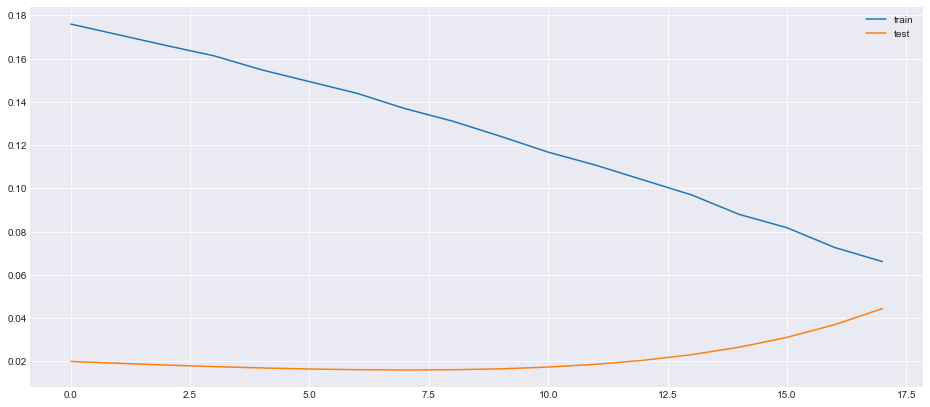

In [20]:
## Visualise Loss

plt.figure(figsize=(16,7))
plt.plot(history.history['loss'], label='train')

plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [22]:
# Transformation to original form and making the predictions

predicted_disease_cases = regressor.predict(testX)
# test_predicted = model_from_saved_checkpoint.predict(testing_data_X)

predicted_disease_cases  = scaler_test.inverse_transform(predicted_disease_cases .reshape(-1, 1))
test_actual = scaler_test.inverse_transform(testY.reshape(-1, 1))

1/1 [==============================] - 0s 29ms/step


In [23]:
test_actual

array([[543.],
       [ 48.],
       [ 96.],
       [130.],
       [ 57.],
       [  6.],
       [  1.],
       [  4.],
       [  0.],
       [ 34.],
       [ 18.],
       [  8.]])

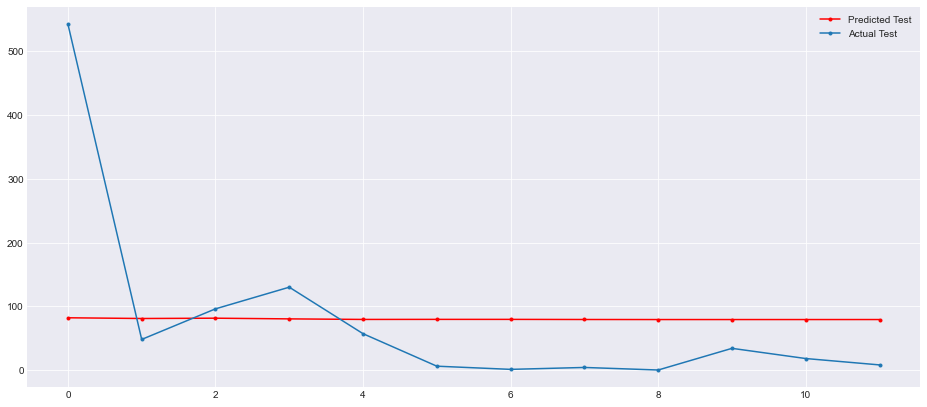

In [25]:
plt.figure(figsize=(16,7))

plt.plot(predicted_disease_cases , 'r', marker='.', label='Predicted Test')

plt.plot(test_actual, marker='.', label='Actual Test')

plt.legend()
plt.show()

In [26]:
testX.shape

(12, 3, 1)

In [27]:
## Future 5 days

testX.shape
look_back_years = 5
past_years = testX[testX.shape[0] - look_back_years :]

past_years.shape
past_years

future_years = []
for i in range(4):
    forecast_test_x = model_from_saved_checkpoint.predict(past_years[i:i+1])
    forecast_test_x = scaler_test.inverse_transform(forecast_test_x.reshape(-1,1))
    future_years.append(forecast_test_x)

print ("Forecast:", np.array(future_years))



1/1 [==============================] - 0s 21ms/step
Forecast: [[[79.28294 ]]

 [[79.19345 ]]

 [[79.18691 ]]

 [[79.197586]]]


In [29]:
def rmse(actual, predict):

    predict = np.array(predict)
    actual = np.array(actual)
    mse = mean_squared_error(actual, predict)
    rmse = math.sqrt(mse)
    return rmse

rmse(test_actual, predicted_disease_cases )

144.67242195872672